Import Python Libraries

In [1]:
import os
import numpy as np
import numpy.ma as ma
from glob import glob
from time import strptime
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

from IPython.display import Image, display

import scipy.io as sio
import xarray as xr

1.	Read the daily SST data from 1 Jan 1979- 31 Dec 2017 – for all tasks below use SST in C

In [2]:
filename_pattern  = '/home/voyager-sbarc/arc/reanalysis/erai/sfc/erai.sst.*'
erai_files = glob(filename_pattern) # search files 
erai_files.sort()

for ifile, file, in enumerate(erai_files):
    file_object = sio.readsav(file, python_dict=False,verbose=False)
    lons = file_object['rlon']
    lats = file_object['rlat']
    values0 = file_object['erai_sst']-273.15 ## convert to celsius
    
    if ifile == 0:
        values = values0
    else:
        values = ma.concatenate((values, values0))

In [3]:
## create array of times - daily between Jan 1, 1979 and Dec 31, 2017
def date_range(start_date, end_date, increment, period):
    result = []
    nxt = start_date
    delta = relativedelta(**{period:increment})
    while nxt <= end_date:
        result.append(nxt)
        nxt += delta
    return result

start = str('1979-01-01-00')
end = str('2017-12-31-18')
start_date = datetime.strptime(start, '%Y-%m-%d-%H')
end_date = datetime.strptime(end, '%Y-%m-%d-%H')
times_list = date_range(start_date, end_date, 1, 'days')
times = np.array(times_list)
print(times.shape)

(14245,)


In [4]:
## Read all data into single xarray dataset 
## this makes it easier to index bounds and do climatology stuff
ds = xr.Dataset({'sst': (['time', 'lat', 'lon'], values)},
                coords={'time': times,
                        'lat': (['lat'], lats),
                        'lon': (['lon'], lons)})
ds

<xarray.Dataset>
Dimensions:  (lat: 256, lon: 512, time: 14245)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2017-12-31
  * lat      (lat) >f4 -89.46282 -88.76695 -88.06697 ... 88.76695 89.46282
  * lon      (lon) >f4 0.0 0.703 1.406 2.109 ... 357.124 357.827 358.53 359.233
Data variables:
    sst      (time, lat, lon) float32 9725.85 9725.85 ... -1.6902161 -1.6902161

2.	Compute the daily mean SST in the NINO34 region; your time series will run from 1 Jan 1979 to 31 Dec 2017; each value is the mean SST in the NINO34 region

In [5]:
## Average area of NINO 3.4 region
##  region 5°N-5°S, 120°- 170°W
NINO34 = ds.sel(lat=slice(-5,5), lon=slice(360-170, 360-120))
NINO34 = NINO34.mean(('lat', 'lon'))
NINO34

<xarray.Dataset>
Dimensions:  (time: 14245)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2017-12-31
Data variables:
    sst      (time) float32 26.604568 26.600039 26.595533 ... 25.732569 25.74347

#### Plot Area-Average NINO3.4 

Text(0.5, 1.0, 'NINO 3.4 SST (*C)')

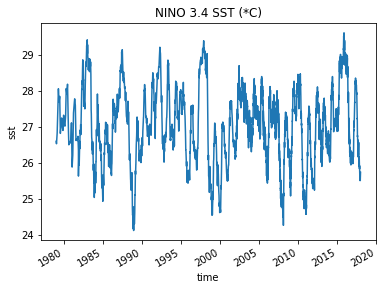

In [6]:
NINO34.sst.plot()
plt.title('NINO 3.4 SST (*C)')

3.	Compute the daily climatological SST: your time series will have 365 values; first value is 1 January, which is the average of all 1 January values from 1979-2017, second value is 2 January, which is the average of all 2 January values from 1979-2017 etc.

In [7]:
climatology = NINO34.groupby('time.dayofyear').mean('time')
climatology

<xarray.Dataset>
Dimensions:    (dayofyear: 366)
Coordinates:
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 360 361 362 363 364 365 366
Data variables:
    sst        (dayofyear) float32 26.521616 26.515951 ... 26.511227 25.910412

#### Plot Annual Climatology

Text(0.5, 1.0, 'Annual Climatology for NINO 3.4 SST (*C)')

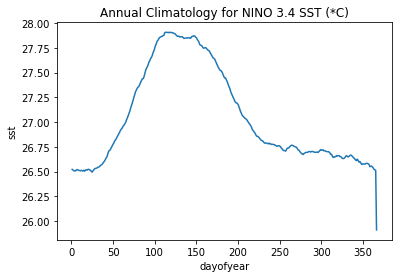

In [8]:
climatology.sst.plot()
plt.title('Annual Climatology for NINO 3.4 SST (*C)')

4.	Make a plot with daily SST from 1 January 1996 to 31 December 1998
5.	Over-plot the daily climatological mean SST (computed in #3) on the plot made in #4; you will need to over-plot three cycles of the daily climatological mean SST.

In [9]:
## Slice data from Jan 1 1996 to Dec 31 1998
NINO34_1996_1998 = NINO34.sel(time=slice('1996-01-01', '1998-12-31'))
NINO34_1996_1998

<xarray.Dataset>
Dimensions:  (time: 1096)
Coordinates:
  * time     (time) datetime64[ns] 1996-01-01 1996-01-02 ... 1998-12-31
Data variables:
    sst      (time) float32 25.609512 25.592564 25.57591 ... 24.820047 24.820047

In [10]:
## This stacks the annual cycle together 3x for the three years
## removing the leap day for years 1997 and 1998
climatology_stack = np.concatenate([climatology.sst, 
                                    climatology.sst[:59], climatology.sst[60:], 
                                    climatology.sst[:59], climatology.sst[60:]])
climatology_stack.size

1096

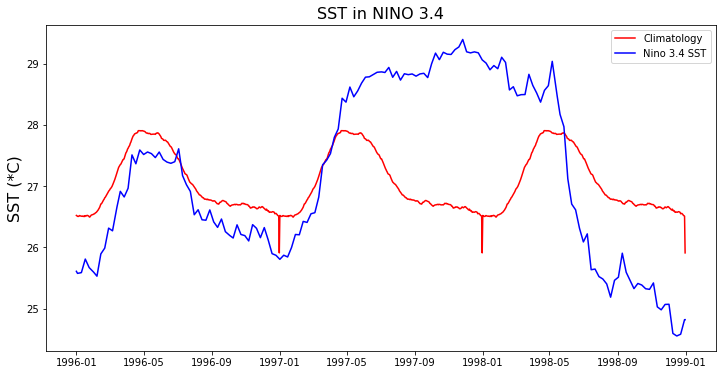

In [11]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)
ax.plot_date(NINO34_1996_1998.time, climatology_stack, 'r', label='Climatology')
ax.plot_date(NINO34_1996_1998.time, NINO34_1996_1998.sst, 'b', label='Nino 3.4 SST')
plt.ylabel('SST (*C)', fontsize=16)
plt.title('SST in NINO 3.4', fontsize=16)
ax.legend()
fig.savefig('./results/fig1.png', dpi = 300)


6.	Is your daily climatological SST a good estimate for the annual cycle in SST?

No the daily climatological SST is not a good estimate for the annual cycle in SST. First off, there is a dramatic decrease for December 31 (about 1 degree Celsius) that seems too dramatic. Also, while the annual cycle climatology seems to fit okay to the year 1996, it is not really a great fit for 1997 and 1998. For example, the plot above, shows that SST between May 1997 and May 1998 was unusually warm and did not really follow a traditional annual cycle. Running filters and possibly using the first two harmonics might make the annual cycle a better fit. 